# Solution

A simplified 2D car navigation system is equipped with three sensors that each contribute with information for the system to make estimates of position and velocity.

The sensors are: 
1. GNSS receiver (2D positions)
2. digital compass (heading)
3. speed (taken from the gearbox)

Implement the navigation system as a Kalman Filter that fuses these three sensors and make estimates of the  position and velocity given the measurements.

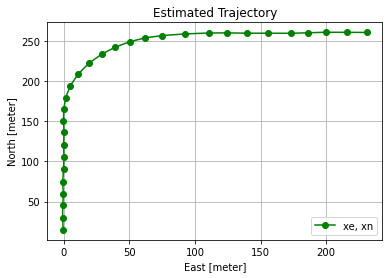

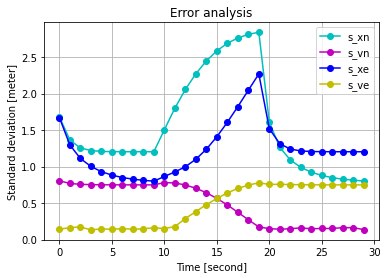

In [1]:
from numpy import array, arange, sqrt, nan, isnan, diag, kron, eye, zeros, block, any, pi, sin, cos
from numpy.linalg import inv
import matplotlib.pyplot as plt
from vanloan import numeval

# measurements: time [second], east [meter], north [meter], heading [degree], speed [meter/second]
meas = array([[ 1.0000,    -0.6364,    14.7859,          0,    14.2829],
              [ 2.0000,    -1.7202,    28.7619,          0,    16.4726],
              [ 3.0000,    -0.2923,    45.7914,          0,    17.6227],
              [ 4.0000,     0.6875,    56.6706,          0,    13.2916],
              [ 5.0000,    -2.4761,    76.4568,          0,    14.7736],
              [ 6.0000,     2.3829,    90.9508,          0,    14.1406],
              [ 7.0000,     1.4643,   104.9209,          0,    15.2224],
              [ 8.0000,    -1.2322,   123.5090,          0,    14.1959],
              [ 9.0000,     1.6036,   138.6996,          0,    14.8816],
              [10.0000,    -2.5183,   146.4271,          0,    16.4225],
              [11.0000,        nan,        nan,     2.2489,    14.8143],
              [12.0000,        nan,        nan,     9.0000,    13.1819],
              [13.0000,        nan,        nan,    18.0000,    16.7117],
              [14.0000,        nan,        nan,    27.0000,    16.4481],
              [15.0000,        nan,        nan,    36.0000,    16.5388],
              [16.0000,        nan,        nan,    45.0000,    14.1227],
              [17.0000,        nan,        nan,    54.0000,    13.8812],
              [18.0000,        nan,        nan,    63.0000,    12.4314],
              [19.0000,        nan,        nan,    72.0000,    12.7910],
              [20.0000,        nan,        nan,    83.2532,    14.7591],
              [21.0000,    94.6201,   258.2167,    90.0000,    15.1392],
              [22.0000,   115.1994,   260.5579,    90.0000,    14.1821],
              [23.0000,   121.3225,   260.2637,    90.0000,    15.0477],
              [24.0000,   139.6745,   258.2903,    90.0000,    16.1060],
              [25.0000,   158.1072,   259.0383,    90.0000,    14.9329],
              [26.0000,   175.6130,   258.8439,    90.0000,    15.3365],
              [27.0000,   181.3569,   262.7220,    90.0000,    15.3599],
              [28.0000,   196.0819,   263.7981,    90.0000,    16.4810],
              [29.0000,   216.7709,   259.7998,    90.0000,    16.4366],
              [30.0000,   231.5194,   259.4486,    90.0000,    13.7347]])


# System parameters
samples = 30           # Number of samples
dt = 1                 # Time interval [second]

# Prosess noise variance
q = 1**2              # Velocity variance per second [(meter^2/second^2)/second]

# Measurement noise variance
rp = 2**2              # Position [meter^2]
rs = 1**2              # Speed [meter^2/second^2]
rh = 0.01**2           # Heading  [degree^2]

Rsh = diag([rs, rh])   # Speed/Heading covariance matrix
Rp = diag([rp, rp])    # Position covariance matrix

# Dynamic matrix
F = array([[0, 1, 0, 0],
           [0, 0, 0, 0],
           [0, 0, 0, 1],
           [0, 0, 0, 0]])

# White noise coefficients
G = array([[0, 0],
           [sqrt(q), 0],
           [0, 0],
           [0, sqrt(q)]])

# Numerical evaluation (van loan)
[phi, Q] = numeval(F, G, dt)

# Initial state vector
x = array([[0],       # North [meter]
           [15],      # North velocity [meter/second]
           [0],       # East [meter]
           [0]])      # East velocity [meter/second]

# Inital state vector covariance
P = kron(eye(2), [[3**2, 0],
                  [0, 1**2]])

# Initial plot vectors
x_all = []; P_all = []

# KF main loop
for k in range(samples):
    
    # Time update
    xt = phi@x
    Pt = phi@P@phi.T + Q
    
    # Check if GNSS measurement are available
    if not(any(isnan(meas[k, 1:3]))):

        # GNSS available
        north = meas[k, 2]            # North [meter]
        east = meas[k, 1]             # East [meter]
        head = meas[k, 3]*(pi/180)    # Heading [radian]
        speed = meas[k, 4]            # Speed [meter/second]
        
        # Measurement vector
        z = array([[north],
                   [east],
                   [speed*cos(head)],
                   [speed*sin(head)]])
        
        # Design matrix
        H = array([[1, 0, 0, 0],
                   [0, 0, 1, 0],
                   [0, 1, 0, 0],
                   [0, 0 ,0 ,1]])
        
        # Error propagation R(speed, head) -> R(vn, ve)
        B = array([[cos(head), -speed*sin(head)],
                   [sin(head),  speed*cos(head)]])
        Rv = B@Rsh@B.T
        
        # Measurement covariance matrix
        R = block([[Rp, zeros([2, 2])],
                   [zeros([2, 2]), Rv]])
        
    else:
        
        # GNSS not available
        head = meas[k, 3]*(pi/180)    # Heading [radian]
        speed = meas[k, 4]            # Speed [meter/second]
        
        # Measurement vector
        z = array([[speed*cos(head)],
                   [speed*sin(head)]])
        
        # Design matrix
        H = array([[0, 1, 0, 0],
                   [0, 0 ,0 ,1]])
        
        # Error propagation R(speed, head) -> R(ve, vn)
        B = array([[cos(head), -speed*sin(head)],
                   [sin(head),  speed*cos(head)]])
        Rv = B@Rsh@B.T
        
        # Mesaurement covariance matrix
        R = Rv
        
    # Kalman Gain
    K = Pt@H.T@inv(H@Pt@H.T + R)
    
    # Measurement update
    x = xt + K@(z - H@xt)
    P = (eye(4) - K@H)@Pt
    
    # Accumulate plot vectors
    x_all.append(x)
    P_all.append(P)

# Extract plot vectors
xn = [x[0] for x in x_all]
xe = [x[2] for x in x_all]

s_xn = [sqrt(P[0, 0]) for P in P_all]
s_vn = [sqrt(P[1, 1]) for P in P_all]
s_xe = [sqrt(P[2, 2]) for P in P_all]
s_ve = [sqrt(P[3, 3]) for P in P_all]

# Time vector
time = arange(0, samples)*dt

plt.figure(1)
plt.plot(xe, xn, 'g-o', label = 'xe, xn')
plt.title('Estimated Trajectory')
plt.xlabel('East [meter]')
plt.ylabel('North [meter]')
plt.legend(loc='lower right')
plt.grid(True, which='both')
plt.show()

plt.figure(2)
plt.plot(time, s_xn, 'c-o', label = 's_xn')
plt.plot(time, s_vn, 'm-o', label = 's_vn')
plt.plot(time, s_xe, 'b-o', label = 's_xe')
plt.plot(time, s_ve, 'y-o', label = 's_ve')
plt.title('Error analysis')
plt.xlabel('Time [second]')
plt.ylabel('Standard deviation [meter]')
plt.legend(loc='upper right')
plt.grid(True, which='both')
plt.show()